Download the dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/pavka/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


In [2]:
import numpy
import pandas as pd
import random
from sympy import isprime
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

## <strong> 1. Recommendation System with LSH

## <strong> 1.1 Data Preparation
Download the MovieLens dataset from here. After downloading, explore the dataset to understand the structure and identify any preprocessing steps needed.

<strong> There are in total 6 datasets, let's have a quick look at them

In [75]:
genome_scores = pd.read_csv("dataset/genome_scores.csv", index_col =0)
genome_scores.head(3)

,tagId,relevance
movieId,,
1,1,0.02500
1,2,0.02500
1,3,0.05775


In [76]:
genome_tags = pd.read_csv("dataset/genome_tags.csv", index_col = 0)
genome_tags.head(3)

,tag
tagId,
1,007
2,007 (series)
3,18th century


In [77]:
link = pd.read_csv("dataset/link.csv", index_col = 0)
link.head(3)

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0


In [14]:
movie = pd.read_csv("dataset/movie.csv", index_col = 0)
movie.head(3)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance


In [13]:
rating = pd.read_csv("dataset/rating.csv")
rating.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [80]:
tag = pd.read_csv("dataset/tag.csv", index_col = 0)
tag.head(3)

,movieId,tag,timestamp
userId,,,
18,4141,Mark Waters,2009-04-24 18:19:40
65,208,dark hero,2013-05-10 01:41:18
65,353,dark hero,2013-05-10 01:41:19


In [45]:
# Map movie names into ratings_df
rating= rating.merge(movie, on='movieId')

# Create user_movies dictionary
user_movies = rating.groupby('userId')['movieId'].apply(list).to_dict()

# Create user_ratings dictionary
user_ratings = rating.groupby('userId').apply(
    lambda group: dict(zip(group['movieId'], group['rating']))
).to_dict()

/tmp/ipykernel_66895/1612435243.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_ratings = rating.groupby('userId').apply(



## <strong>1.2 Minhash Signatures</strong>

Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

    -Important: Implement your MinHash function from scratch—do not use any pre-built hash functions.
    -Use your MinHash function to generate signature vectors for each user based on their rated movies.
    -Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.


Let's first group all the users and their correspective movies.

In [46]:
user_movies = rating.groupby('userId')['movieId'].apply(list).to_dict()

Let's define a simple modulo hash function: <br> <br>
$
h(x) = (a \cdot x + b) \mod p
$

Where:  
- $ x $: Input value  
- $ a $: Coefficient (non-zero)  
- $ b $: Coefficient  
- $ p $: Prime modulus

In [17]:
def hash_function(x, a ,b ,p): 
    return (a*x + b) % p

We generate multiple hash functions.

In [18]:
def create_hash_functions(max_value, max_prime):
    
    primes = [i for i in range(10,max_prime) if isprime(i)]

    # Generate multiple hash functions
    hash_functions = []
    for i in range(10):
        a = random.randint(1, max_value)  # Random coefficient a (non-zero)
        b = random.randint(0, max_value)  # Random coefficient b
        p = random.choice(primes)  # Predefined prime values
        
        hash_functions.append(lambda x, a=a, b=b, p=p: hash_function(x, a, b, p))
    return hash_functions

Now given these hash functions, we create our signature matrix.

In [19]:
def minhash(user_movies, hash_functions):
    signature_matrix = {}

    for user, movies in user_movies.items():
        signature_vector = []
        for h in hash_functions:
            min_hash = min(h(movie) for movie in movies)  # Compute min hash value for the user's movies
            signature_vector.append(min_hash)
        signature_matrix[user] = signature_vector
    
    return signature_matrix

In [47]:
user_signatures = minhash(user_movies,create_hash_functions(max_value = 10000, max_prime = 1000000))

### **Effectiveness of the Hashing Function**

To evaluate the effectiveness of our MinHash function, we compare the **Jaccard similarity** of two sets with the **MinHash similarity** of their corresponding signature matrices. We then calculate the error using the squared Euclidean distance between the two similarities.

#### 1. **Jaccard Similarity**

The Jaccard similarity between two sets $A $ and $B $ is defined as:

$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$

#### 2. **MinHash Similarity**

The MinHash similarity between two signature vectors $\text{sig}_1 $ and $\text{sig}_2 $ is given by:

$
\text{MinHashSim}(\text{sig}_1, \text{sig}_2) = \frac{\text{Number of Matching Hashes}}{\text{Total Number of Hashes}}
$

$
\text{MinHashSim}(\text{sig}_1, \text{sig}_2) = \frac{\sum_{i=1}^n \mathbb{1}(\text{sig}_1[i] = \text{sig}_2[i])}{n}
$

where $\mathbb{1} $ is the indicator function that returns $1 $ if the elements are equal and $0 $ otherwise.

#### 3. **Error Calculation**

The error is computed as the squared Euclidean distance between the true Jaccard similarity and the MinHash similarity:

$
\text{Error} = (J(A, B) - \text{MinHashSim}(\text{sig}_1, \text{sig}_2))^2
$

#### 4. **Total Error Across Users**

For all pairs of users \((u_1, u_2)$, the total error is computed as:

$
\text{Total Error} = \frac{\sum_{(u_1, u_2) \in \text{Users}} \text{Error}(u_1, u_2)}{|\text{Users}|^2}
$

Where:
- $\text{Users} $ is the set of all user pairs.
- $\text{Error}(u_1, u_2) $ is the squared Euclidean error for a pair of users.


In [11]:
# For simplicity we only ran 10000 lines including 90 users

# True Jaccard similarity
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

# MinHash similarity
def minhash_similarity(sig1, sig2):
    return sum(1 for a, b in zip(sig1, sig2) if a == b) / len(sig1)

# Evaluate effectiveness
def evaluate_effectiveness(user_movies, signature_matrix):
    users = list(user_movies.keys())

    tot_error = 0
    for user1, user2 in combinations(users, 2):
        set1, set2 = set(user_movies[user1]), set(user_movies[user2])
        sig1, sig2 = signature_matrix[user1], signature_matrix[user2]
        
        # Compute similarities
        true_jaccard = jaccard_similarity(set1, set2)
        approx_minhash = minhash_similarity(sig1, sig2)
        
        # Calculate Error
        error = (true_jaccard - approx_minhash)**2
        tot_error += error
    
    return tot_error / (len(users)**2)


Let's test our results given different types of values for the hashing function.

In [ ]:
results = []
parameters = []
for i in range(10,1000,5):
    parameters.append(i)
    hash_functions = create_hash_functions(i, i*2)
    signature_matrix = minhash(user_movies,hash_functions)
    result = evaluate_effectiveness(user_movies,signature_matrix)
    results.append(result)

Let's plot the results.

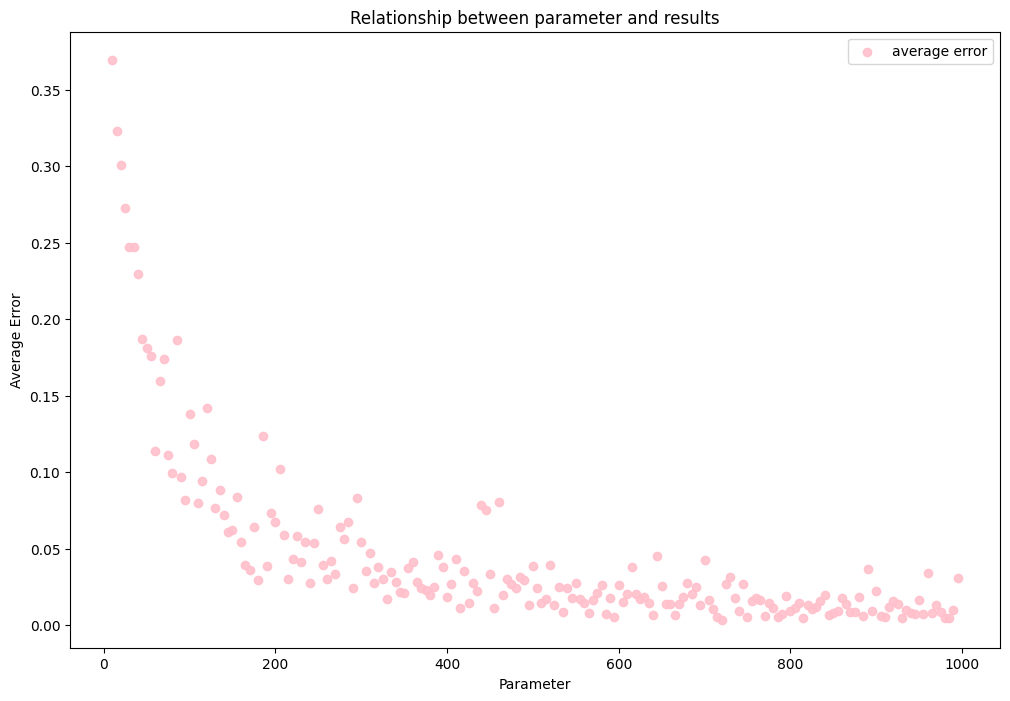

In [ ]:
plt.figure(figsize=(12, 8))  
plt.scatter(parameters, results, color='pink', label='average error',alpha = 0.9)  # Plot points
plt.title("Relationship between parameter and results")  
plt.xlabel("Parameter") 
plt.ylabel("Average Error") 
plt.legend() 
plt.show()

We can clearly see a direct relationship between the maximum value in the hashing function and the error. As the maximum value grows, the likelihood of hash collisions decreases, resulting in a better approximation of the true Jaccard similarity and a reduction in error.

## <strong> 1.3 Locality-Sensitive Hashing (LSH) </strong>

### <strong> 1.3.1 Bucket Creation: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

We create a custom hashing function for buckets

In [48]:
def custom_bucket_hash(sig):
    return sum(sig) % 1001

In [49]:
def lsh(minhash_signatures, num_bands):
    """
    Locality-Sensitive Hashing (LSH) for clustering similar users.

    Args:
        minhash_signatures (dict): Dictionary mapping user IDs to their MinHash signatures.
        num_bands (int): Number of bands to divide the signature into.

    Returns:
        buckets (defaultdict): Mapping from bucket keys to sets of user IDs.
    """
    # Initialize buckets
    buckets = defaultdict(set)
    num_rows = len(next(iter(minhash_signatures.values()))) // num_bands  # Rows per band

    # Create buckets for each band
    for user, signature in minhash_signatures.items():
        for band_idx in range(num_bands):
            # Extract rows for the current band
            start = band_idx * num_rows
            end = start + num_rows
            band = tuple(signature[start:end])  # Ensure immutability for hashing
            # Hash the band and add the user to the corresponding bucket
            bucket_key = custom_bucket_hash(band)
            buckets[bucket_key].add(user)
    
    return buckets



### <strong>  1.3.2 Query: For a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.

In [50]:
def query_similar_users(user, minhash_signatures, buckets):
    """
    Query the most similar users for a given user using LSH buckets.

    Args:
        user (str): User ID for whom to find similar users.
        minhash_signatures (dict): MinHash signatures for all users.
        buckets (defaultdict): Buckets created using LSH.

    Returns:
        List[Tuple[str, float]]: Two most similar users and their MinHash similarity scores.
    """
    user_signature = minhash_signatures[user]
    similar_users = set()

    # Find all buckets containing the given user
    for bucket_users in buckets.values():
        if user in bucket_users:
            similar_users.update(bucket_users)
    
    # Remove the queried user from the set of similar users
    similar_users.discard(user)

    # Compute MinHash similarities
    similarities = [
        (other_user, minhash_similarity(user_signature, minhash_signatures[other_user]))
        for other_user in similar_users
    ]

    # Sort by similarity in descending order and return the top two
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:2]


In [51]:
# Apply LSH
num_bands = 3  # Choose the number of bands
buckets = lsh(user_signatures, num_bands)


# Query similar users for "user1"
similar_users = query_similar_users(1, user_signatures, buckets)
print(f"Similar users for 'user1': {similar_users}")

Similar users for 'user1': [(41059, 0.4), (84182, 0.4)]


### <strong> 1.3.3 Movie Recommendation Logic: </strong>

    If both similar users have rated a movie, recommend this movie based on the average rating.
    If there are no commonly rated movies, recommend the top-rated movies of the most similar user.



In [52]:
def recommend_movies(target_user, user_movies, user_ratings, similar_users, max_recommendations=5):
    """
    Recommends movies for a target user based on similar users' ratings.

    Args:
        target_user (str): The user for whom recommendations are generated.
        user_movies (dict): Movies watched by each user.
        user_ratings (dict): Ratings given by each user for movies.
        similar_users (list): Two most similar users (in descending similarity order).
        max_recommendations (int): Maximum number of recommendations.

    Returns:
        List[Tuple[str, float]]: Recommended movies and their ratings.
    """
    # Movies rated by the target user
    target_user_movies = set(user_movies[target_user])
    
    # Movies rated by similar users
    similar_user_1, similar_user_2 = similar_users
    user1_movies = set(user_movies[similar_user_1])
    user2_movies = set(user_movies[similar_user_2])

    # Find common movies and compute average ratings
    common_movies = user1_movies & user2_movies
    recommendations = []
    for movie in common_movies:
        movie1 = user_ratings[similar_user_1][movie]
        movie2 = user_ratings[similar_user_2][movie]
        avg_rating = (movie1 + movie2) / 2
        recommendations.append((movie, avg_rating))

    # Sort recommendations by average rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Add top-rated movies from the most similar user
    most_similar_user = similar_user_1
    for movie, rating in sorted(user_ratings[most_similar_user].items(), key=lambda x: x[1], reverse=True):
        if len(recommendations) >= max_recommendations:
            break
        if movie not in target_user_movies and movie not in [rec[0] for rec in recommendations]:
            recommendations.append((movie, rating))
    
    # Fill up to 5 recommendations using the second most similar user if needed
    if len(recommendations) < max_recommendations:
        for movie, rating in sorted(user_ratings[similar_user_2].items(), key=lambda x: x[1], reverse=True):
            if len(recommendations) >= max_recommendations:
                break
            if movie not in target_user_movies and movie not in [rec[0] for rec in recommendations]:
                recommendations.append((movie, rating))
    
    return recommendations[:max_recommendations]


In [ ]:
target = 1
similar_users = [user for user, score in query_similar_users(target,user_signatures,buckets)]
recommendations = recommend_movies(target_user=1, 
                                   user_movies=user_movies, 
                                   user_ratings=user_ratings, 
                                   similar_users=similar_users)

### <strong> 1.3.4 Final Recommendation: Provide at most five movies to the user.

In [58]:
recommendations_df = pd.DataFrame(recommendations, columns=['movieId', 'score'])
result_df = recommendations_df.merge(movie, on='movieId', how='left')
result_df[['title', 'score']]

,title,score
0,Full Metal Jacket (1987),4.5
1,"Matrix, The (1999)",4.5
2,Alien (1979),4.5
3,"Truman Show, The (1998)",4.5
4,Highlander (1986),4.5
